In [1]:
# cat -> 0
# dog -> 1

# input data -> 224x224x3 image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image   
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:

train_x = []
train_y = []

valid_x = []
valid_y = []


# load data
for i in os.listdir('train/cats'):
    img = Image.open('train/cats/'+i)
    # for angle in [0, 90, 180, 270]: # 상하좌우
    #     img_rotate = img.rotate(angle)
    #     img_resize = img_rotate.resize((224,224))
    #     train_x.append(np.array(img_rotate).reshape(224,224,3))
    #     train_y.append(0)
    img_resize = img.resize((224,224))
    train_x.append(np.array(img_resize).reshape(224,224,3))
    train_y.append(0)
    
for i in os.listdir('train/dogs'):
    img = Image.open('train/dogs/'+i)
    # for angle in [0, 90, 180, 270]: # 상하좌우
    #     img_rotate = img.rotate(angle)
    #     img_resize = img_rotate.resize((224,224))
    #     train_x.append(np.array(img_rotate).reshape(224,224,3))
    #     train_y.append(1)
    img_resize = img.resize((224,224))
    train_x.append(np.array(img_resize).reshape(224,224,3))
    train_y.append(1)


for i in os.listdir('validation/cats'):
    img = Image.open('validation/cats/'+i)
    valid_x.append(np.array(img.resize((224,224))).reshape(224,224,3))
    valid_y.append(0)
        
        

for i in os.listdir('validation/dogs'):
    img = Image.open('validation/dogs/'+i)
    valid_x.append(np.array(img.resize((224,224))).reshape(224,224,3))
    valid_y.append(1)

train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)

(2000, 224, 224, 3) (2000,) (1000, 224, 224, 3) (1000,)


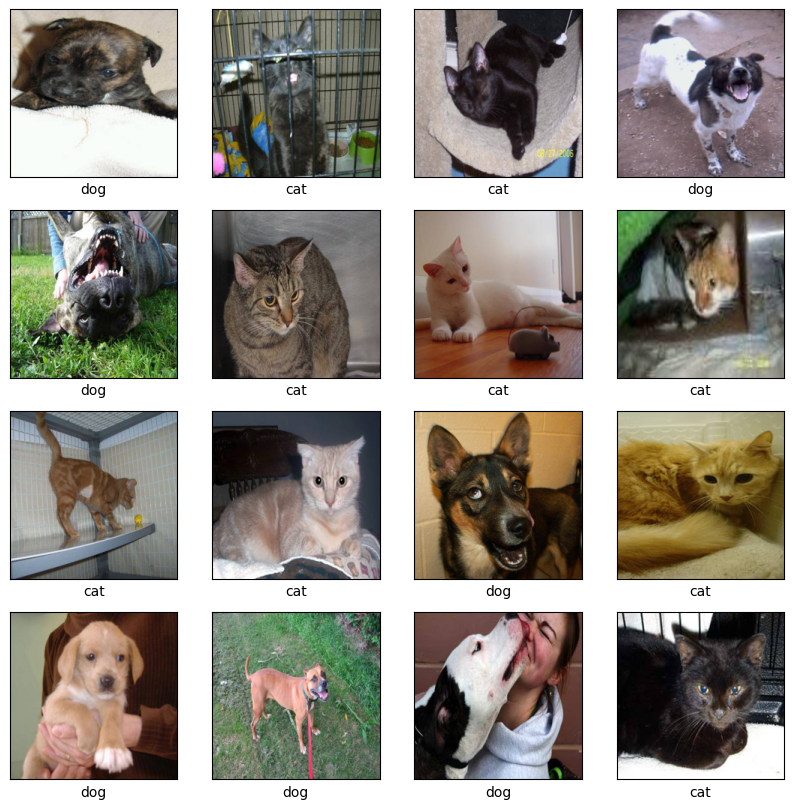

In [3]:
samples = np.random.randint(train_x.shape[0], size=16)

feature_mapping = {0:'cat', 1:'dog'}

plt.figure(figsize=(10,10))
for i, idx in enumerate(samples):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_x[idx])
    plt.xlabel(feature_mapping[train_y[idx]])

In [4]:
# data suffle
index = np.arange(0, len(train_x))
np.random.shuffle(index)
train_x = train_x[index]
train_y = train_y[index]

index = np.arange(0, len(valid_x))
np.random.shuffle(index)
valid_x = valid_x[index]
valid_y = valid_y[index]

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
print(pd.Series(train_y).value_counts())
print(pd.Series(valid_y).value_counts())

(2000, 224, 224, 3) (2000,) (1000, 224, 224, 3) (1000,)
0    1000
1    1000
Name: count, dtype: int64
1    500
0    500
Name: count, dtype: int64


In [5]:
# 정규화

train_x_s = train_x.astype('float32')/255
valid_x_s = valid_x.astype('float32')/255

In [6]:
# train_x_s의 각 데이터를 90도, 180도, 270도 회전한 데이터를 추가

train_x_s_90 = np.array([np.rot90(i) for i in train_x_s])
train_x_s_180 = np.array([np.rot90(i, 2) for i in train_x_s])
train_x_s_270 = np.array([np.rot90(i, 3) for i in train_x_s])

train_x_s = np.concatenate((train_x_s, train_x_s_90, train_x_s_180, train_x_s_270), axis=0)

train_y_s = np.concatenate((train_y, train_y, train_y, train_y), axis=0)

print(train_x_s.shape, train_y_s.shape)



(8000, 224, 224, 3) (8000,)


In [7]:
valid_x_s_90 = np.array([np.rot90(i) for i in valid_x_s])
valid_x_s_180 = np.array([np.rot90(i, 2) for i in valid_x_s])
valid_x_s_270 = np.array([np.rot90(i, 3) for i in valid_x_s])

valid_x_s = np.concatenate((valid_x_s, valid_x_s_90, valid_x_s_180, valid_x_s_270), axis=0)

valid_y_s = np.concatenate((valid_y, valid_y, valid_y, valid_y), axis=0)

print(valid_x_s.shape, valid_y_s.shape)

(4000, 224, 224, 3) (4000,)


In [8]:
# one-hot encoding

from keras.utils import to_categorical

train_y_o = to_categorical(train_y_s)
valid_y_o = to_categorical(valid_y_s)

print(train_y_o.shape, valid_y_o.shape)

(8000, 2) (4000, 2)


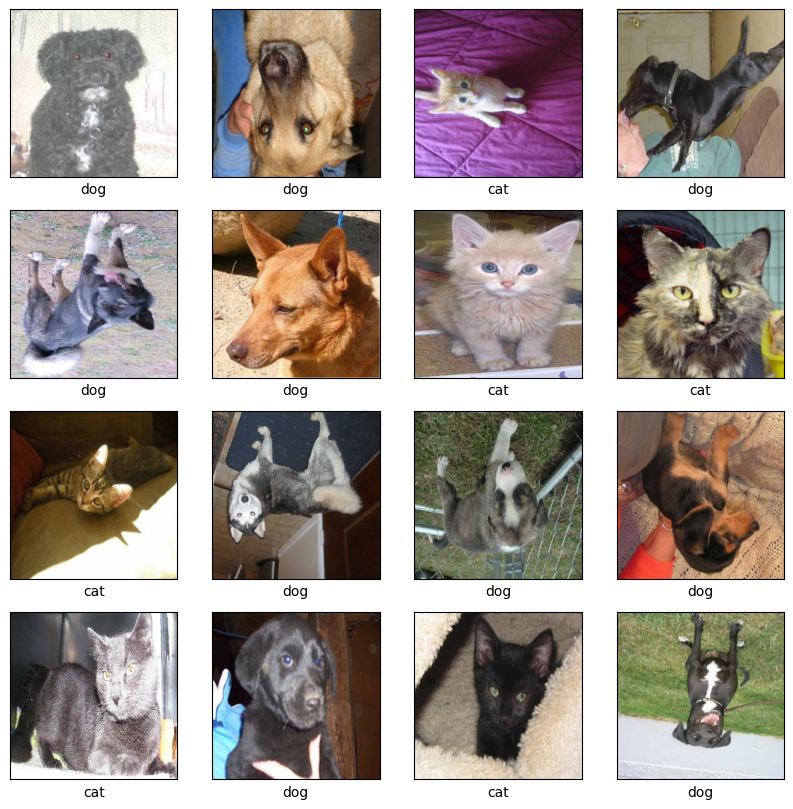

In [9]:
samples = np.random.randint(train_x_s.shape[0], size=16)
plt.figure(figsize=(10,10))

for i, idx in enumerate(samples):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_x_s[idx])
    plt.xlabel(feature_mapping[train_y_s[idx]])

In [10]:
# 모델링

from keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(224,224,3)),
    layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224,224,3)),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    # layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    # layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    # layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(train_x_s, train_y_o, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(valid_x_s, valid_y_o))

Epoch 1/10


2024-01-02 16:14:01.580593: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 109s 434ms/step - loss: 0.7014 - accuracy: 0.5369 - val_loss: 0.6773 - val_accuracy: 0.6008
Epoch 2/10
250/250 [==============================] - 127s 508ms/step - loss: 0.6720 - accuracy: 0.5938 - val_loss: 0.6630 - val_accuracy: 0.6140
Epoch 3/10
250/250 [==============================] - 130s 520ms/step - loss: 0.6217 - accuracy: 0.6555 - val_loss: 0.6218 - val_accuracy: 0.6590
Epoch 4/10
250/250 [==============================] - 123s 491ms/step - loss: 0.5739 - accuracy: 0.7014 - val_loss: 0.5805 - val_accuracy: 0.7103
Epoch 5/10
250/250 [==============================] - 131s 523ms/step - loss: 0.5227 - accuracy: 0.7440 - val_loss: 0.5619 - val_accuracy: 0.7140
Epoch 6/10
250/250 [==============================] - 132s 530ms/step - loss: 0.4696 - accuracy: 0.7763 - val_loss: 0.5792 - val_accuracy: 0.7180
Epoch 7/10
250/250 [==============================] - 137s 547ms/step - loss: 0.4066 - accuracy: 0.8062 - val_loss: 0.6657 - val_accura

In [16]:
# ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator(
    
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])